In [ ]:
# import sys

# class Logger(object):
#     def __init__(self, filename="tensorflow_logs.log"):
#         self.terminal = sys.stdout
#         self.log = open(filename, "a")

#     def write(self, message):
#         self.terminal.write(message)
#         self.log.write(message)

#     def flush(self):
#         # 이 메소드는 flush() 인터페이스를 유지하기 위한 것입니다.
#         pass

# sys.stdout = Logger("tensorflow_logs.log")

# # 테스트 출력
# print("This will be written to both console and file")


In [ ]:
import numpy as np

datasets = np.load('npz/ObjectDetection.npz', allow_pickle=True)
images, numbers, bboxes = datasets['images'], datasets['numbers'], datasets['bboxes']

max_label_length = 4
labels = []
for num in numbers:
    cls = [1] * num if num != 0 else [0]
    cls += [0] * (max_label_length - len(cls))
    labels.append(cls)

# labels = np.array(labels)
expected_image_shape = images[9000].shape
expected_bbox_shape = bboxes[9000].shape
expected_label_length = bboxes[9000].shape

non_zero_indices = np.where(numbers != 0)[0]

images_filtered = images[non_zero_indices]
bboxes_filtered = bboxes[non_zero_indices]
labels_filtered = np.array(labels)[non_zero_indices]
# labels = np.array(labels)


for i in range(len(images_filtered)):
    image = images_filtered[i]
    bbox = bboxes_filtered[i]
    label = labels_filtered[i]

    # 이미지 형태와 데이터 타입 검증
    if image.shape != expected_image_shape or image.dtype != np.uint8:
        print(f"이미지 {i}의 형태 또는 데이터 타입이 잘못되었습니다: 형태={image.shape}, 데이터 타입={image.dtype}")

    # 바운딩 박스 형태와 데이터 타입 검증
    if bbox.shape != expected_bbox_shape or bbox.dtype != np.float64:
        print(f"바운딩 박스 {i}의 형태 또는 데이터 타입이 잘못되었습니다: 형태={bbox.shape}, 데이터 타입={bbox.dtype}")

    # # 레이블 길이와 데이터 타입 검증
    # if len(label) != expected_label_length or not all(isinstance(x, int) for x in label):
    #     print(f"레이블 {i}의 길이 또는 데이터 타입이 잘못되었습니다: 길이={len(label)}, 레이블={label}")

print(images.shape, numbers.shape, bboxes.shape, len(labels))

print(images.max(), images.min())
print(bboxes[9000:9010])
print(labels[9000:9010])


dataset = {
    'images' : images_filtered,
    'bboxes' : bboxes_filtered,
    'cls' : labels_filtered
}

print(dataset['images'].shape)
print(dataset['bboxes'].shape)
print(dataset['cls'])


In [ ]:
print(labels[9000])

2024-01-22 12:23:16.593468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(24, 32, 1)
24
24
tf.Tensor(
[[11.  0. 20.  4.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float64)


2024-01-22 12:23:26.594325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-01-22 12:23:26.598171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22292 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-01-22 12:23:26.600151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22292 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-01-22 12:23:26.603294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22292 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

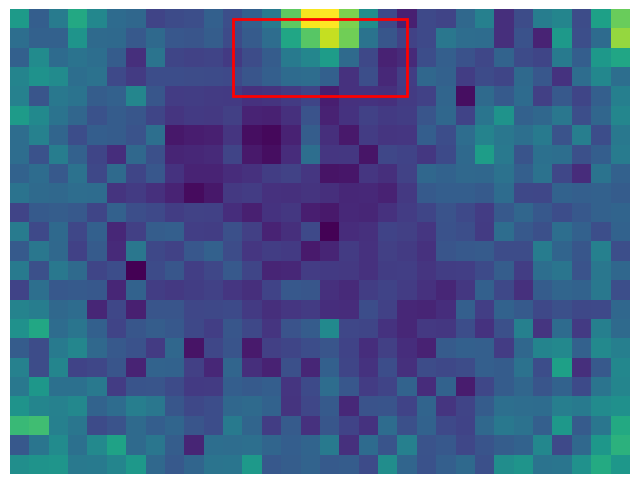

[1 0 0 0]


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
images = dataset['images']
# numbers =dataset['numbers']
bboxes = dataset['bboxes']
cls = dataset['cls']

boxes = bboxes[0]
plt.figure(figsize = (8, 8))
plt.axis('off')
image = images[0]
print(image.shape)
print(image.shape[0])
print(image.shape[0])
plt.imshow(images[0])
ax = plt.gca()
boxes = tf.stack([
	boxes[:, 0] * images.shape[2],
	boxes[:, 1] * images.shape[1],
	boxes[:, 2] * images.shape[2],
	boxes[:, 3] * images.shape[1]], axis = -1
)

print(boxes)

for box in boxes:
	xmin, ymin = box[:2]
	w, h = box[2:] - box[:2]
	patch = plt.Rectangle(
		[xmin, ymin], w, h, fill = False, edgecolor = [1, 0, 0], linewidth = 2
	)
	ax.add_patch(patch)
plt.show()
print(cls[0])

In [5]:
import os
import random
import tensorflow as tf

IMG_SIZE_WIDTH = images.shape[2]
IMG_SIZE_HEIGHT = images.shape[1]
N_DATA = images.shape[0]
N_TRAIN = images.shape[0]
# N_VAL = images.shape[0] - N_TRAIN
LOG_DIR = 'ObjectDetectionLog'

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
print("N_DATA:          ", N_DATA)
print("N_TRAIN:         ", N_TRAIN)



shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
# val_idx_list = shuffle_list[N_TRAIN:]

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
# tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)
# writer_val = tf.io.TFRecordWriter(tfr_val_dir)

IMG_SIZE_WIDTH:   32
IMG_SIZE_HEIGHT:  24
N_DATA:           12880
N_TRAIN:          12880


In [6]:
images.max(), images.min()

(255, 0)

In [7]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))


In [8]:

for idx in train_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    class_id = cls[idx]
    # print(len(cls))
    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id, dtype=tf.int32)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
        # 'number': _int64_feature(number)
    }))
    
    writer_train.write(example.SerializeToString())
writer_train.close()


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT =24
RES_WIDTH = 32
# N_EPOCHS = 100
# N_BATCH = 8
# LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
        # 'number': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = image / tf.reduce_max(image)
    image = tf.cast(image, tf.float32) 
    # image = image / tf.reduce_max(image)

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    # num_boxes = tf.shape(bbox)[0] // 4
    bbox = tf.reshape(bbox, [-1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int32)
    
    # number = tf.cast(parsed_features['number'], tf.int64)
    return image, bbox, label


train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
# train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

# val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
# val_dataset = val_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)


In [10]:
import matplotlib.pyplot as plt

for image, bbox, label in train_dataset.take(1):
    image = image.numpy()
    print(image.shape)
    # print(label)
    # # plt.axis('off')
    # plt.imshow(image)
    # ax = plt.gca()  
    # print(bbox)

    # boxes = tf.stack(
    # 	[
    # 	 bbox[:,0] * image.shape[1],
    # 	 bbox[:,1] * image.shape[0],
    # 	 bbox[:,2] * image.shape[1],
    # 	 bbox[:,3] * image.shape[0]
    # 	], axis = -1
    # )
    # print(image.shape)
    # print(boxes)
    # for box in boxes:
    #     xmin, ymin = box[:2]
    #     w, h = box[2:] - box[:2]
    #     patch = plt.Rectangle(
    #         [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
    #     )
    #     ax.add_patch(patch)
    # plt.show()

(24, 32, 1)


In [11]:
def convert_to_xywh(boxes):    
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

In [12]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1
    )



In [13]:
for image, bbox, label in train_dataset.take(1):
    print(bbox)
    print(convert_to_xywh(bbox))

tf.Tensor(
[[0.09375    0.20833333 0.4375     0.5833333 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0.265625  0.3958333 0.34375   0.375    ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]], shape=(4, 4), dtype=float32)


In [14]:
def resize_and_pad_image(image, min_side=96, max_side=128):
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype = tf.float32)
    # print(f"image_shape: {image_shape}")
    ratio = min_side / tf.reduce_min(image_shape)
    # print(f"ratio: {ratio}")
    if ratio * tf.reduce_max(image_shape) > max_side:
      ratio = max_side / tf.reduce_max(image_shape)
    # print(f"ratio: {ratio}")

    new_image_shape = ratio * image_shape
    # print(f"new_image_shape: {new_image_shape}")

    image = tf.image.resize(image, 
                            tf.cast(new_image_shape, dtype=tf.int32), 
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # print(f"image: {image.shape}")

    return image, new_image_shape, ratio


In [15]:
def preprocess_data(image, gt_boxes, cls_ids):
    # image = sample["images"]
    # bbox = sample["bboxes"]
    cls_ids = tf.cast(cls_ids, dtype = tf.int32)
    image, image_shape, _ = resize_and_pad_image(image)
    
    bbox = tf.stack([
        gt_boxes[:, 0] * image_shape[1],
        gt_boxes[:, 1] * image_shape[0],
        gt_boxes[:, 2] * image_shape[1],
        gt_boxes[:, 3] * image_shape[0]],
        axis = -1
    )
    
    bbox = convert_to_xywh(bbox)
    print(image.shape)
    print(bbox.shape)
    print(cls_ids.shape)
    return image, bbox, cls_ids

In [16]:
for image, bbox, label in train_dataset.take(1):
    resize_and_pad_image(image)

tf.Tensor([1 0 0 0], shape=(4,), dtype=int32)
(96, 128, 1)
(4, 4)
(4,)
(96, 128, 1)
(96, 128, 3)
tf.Tensor(
[[34. 38. 44. 36.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


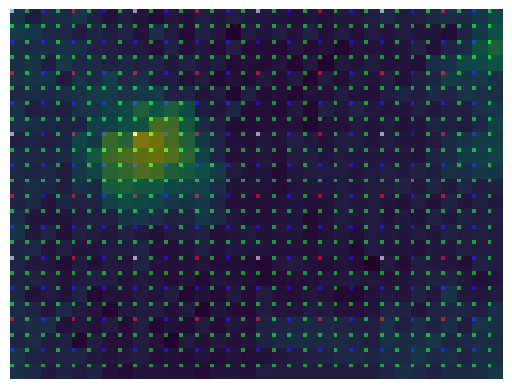

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [17]:
for image, bbox, label in train_dataset.take(1):
    print(label)
    img, bbox, class_id = preprocess_data(image, bbox, label)
    print(img.shape) # (72, 96, 1)

    anchor_img = np.zeros((*img.shape[:2], 3), dtype=np.uint8)
    print(anchor_img.shape)

    print(bbox)

    strides = [4, 8, 16, 32]
    colors = {
        4: [0, 255, 0],  # 초록색
        8: [0, 0, 255],  # 파란색
        16: [255, 0, 0],   # 빨간색
        32:[255, 255, 255],  # 노란색
        # 64:[255, 255, 0],  # 노란색
    }

    for stride in strides:
        color = colors[stride]
        for y in range(0, anchor_img.shape[0], stride):
            for x in range(0, anchor_img.shape[1], stride):
                anchor_img[y, x, :] = color

    # 이미지 표시
    plt.imshow(img, alpha=1)  
    plt.imshow(anchor_img, alpha=0.5) 
    plt.axis('off')
    plt.show()
    print(tf.reduce_max(image), tf.reduce_min(image))

(96, 128, 1)
(4, 4)
(4,)
tf.Tensor([1 0 0 0], shape=(4,), dtype=int32)
tf.Tensor(
[[34. 38. 44. 36.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
width:  128
height:  96
bbox:  tf.Tensor(
[[12. 20. 56. 56.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)


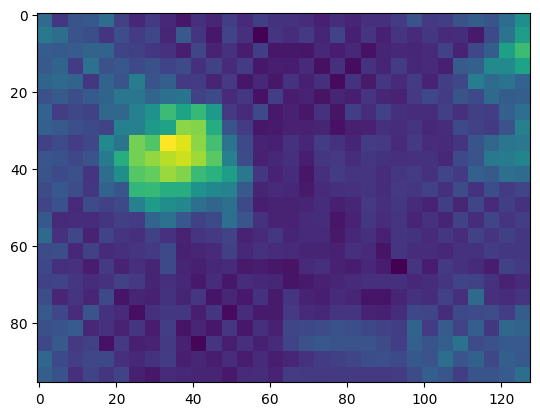

tf.Tensor([1 0 0 0], shape=(4,), dtype=int32)


In [18]:
for image, bbox, label in train_dataset.take(1):
    img, box, label = preprocess_data(image, bbox, label)
    print(label)
    print(box)
    print(tf.reduce_max(image), tf.reduce_min(image))
    # 이미지 시각화
    plt.imshow(img)
    ax = plt.gca()
    width = img.shape[1]
    height = img.shape[0]
    print("width: ", width)
    print("height: ", height)
    boxes = tf.stack(
        [
            (box[:, 0] - 0.5 * box[:, 2])  ,  # xmin = x_center - width/2
            (box[:, 1] - 0.5 * box[:, 3])  ,  # ymin = y_center - height/2
            (box[:, 0] + 0.5 * box[:, 2])  ,  # xmax = x_center + width/2
            (box[:, 1] + 0.5 * box[:, 3])     # ymax = y_center + height/2
        ], axis=-1
    )
    print("bbox: ", boxes)
    # 각 바운딩 박스에 대해 반복하여 그리기
    for box in boxes[2:3]:
        xmin, ymin, xmax, ymax = box
        # print("xmin, ymin: ", xmin, ymin)
        print(box)
        w, h = xmax - xmin, ymax - ymin
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)

    plt.show()
    print(label)


In [19]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]        
        self.scales = [2** x for x in [0, 1/3, 2/3]]
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(2, 10)]
        self._areas = [x ** 2 for x in [4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []

        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios: 
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis = -1), [1, 1, 2]
                )
                for scale in self.scales: 
                    anchor_dims.append(scale * dims) 
            anchor_dims_all.append(tf.stack(anchor_dims, axis = -2))
        return anchor_dims_all 
    
    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype = tf.float32) + 0.5
        ry = tf.range(feature_height, dtype = tf.float32) + 0.5

        centers = tf.stack(tf.meshgrid(rx, ry), axis = -1) * self._strides[level - 2]
        # print(f"centers: {centers}")
        centers = tf.expand_dims(centers, axis = -2)
        # print(f"centers: {centers}")
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        # print(f"centers: {centers}")

        dims = tf.tile(
            self._anchor_dims[level - 2], [feature_height, feature_width, 1, 1] 
        )
        # print(f"dims: {dims}")

        
        anchors = tf.concat([centers, dims], axis=-1) 
        # print(f"anchors: {anchors}")

        # print(f"{tf.reshape(anchors, [feature_height * feature_width * self._num_anchors, 4]).shape}")

        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i), # 올림
                tf.math.ceil(image_width / 2 ** i),
                i
            )
            for i in range(2, 10)
        ]

        anchors = tf.concat(anchors, axis=0)

        # 앵커 박스의 좌표를 이미지 크기 내로 제한
        anchors = tf.clip_by_value(anchors, 0, [image_height, image_width, image_height, image_width])
        return tf.concat(anchors, axis=0)
        # return anchors

Anchor 음수 값: False
(24648, 4)
[[22.        94.         5.4989185  7.331891 ]]


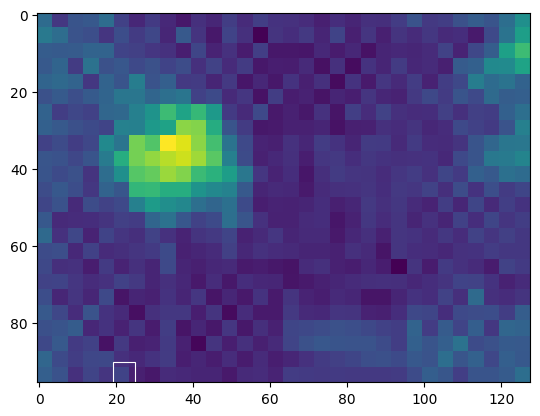

In [20]:
anchors = AnchorBox()
anchor = anchors.get_anchors(96, 128)

has_negative_values = tf.reduce_any(tf.less(anchor, 0))
print("Anchor 음수 값:", has_negative_values.numpy())

# print(anchor)
print(anchor.shape)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(data, num_samples):
    fig, ax = plt.subplots()

    plt.imshow(img)
    # print(img.shape)
    data_np = data.numpy()

    if len(data) > num_samples:
        sampled_indices = np.random.choice(len(data), num_samples, replace=False)
        sample_data = data_np[sampled_indices]
    else : 
        sample_data = data_np
    print(sample_data)
    for center_x, center_y, width, height in sample_data:
        top_left_x = center_x - width / 2
        top_left_y = center_y - height / 2

        rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=0.8, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

draw_bounding_boxes(anchor, 1)


# 24192

In [21]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    print("boxes1: ", boxes1)
    print("boxes1_corners: ", boxes1_corners)
    boxes2_corners = convert_to_corners(boxes2)
    print("boxes2: ", boxes2)
    print("boxes2_corners: ", boxes2_corners)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    print("lu: ", lu)
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])  
    print("rd: ", rd)

    

    intersection = tf.maximum(rd - lu, 0.0)
    print("intersection: ", intersection)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    print("intersection_area: ", intersection_area)
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    print("union_area: ", union_area)
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


In [22]:
b1 = np.array([[70, 62, 16, 16]]) 
b1c = convert_to_corners(b1)
print(b1c)

b2 = np.array([[76, 72, 32, 40]])
b2c = convert_to_corners(b2)
print(b2c)


tf.Tensor([[62. 54. 78. 70.]], shape=(1, 4), dtype=float64)
tf.Tensor([[60. 52. 92. 92.]], shape=(1, 4), dtype=float64)


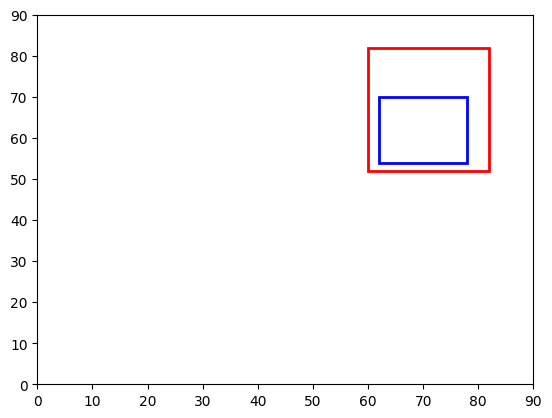

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 주어진 바운딩 박스 데이터
box1 = [62, 54, 78, 70]  # [x_min, y_min, x_max, y_max]
box2 = [60, 52, 82, 82]

# 그림 생성
fig, ax = plt.subplots()

# 첫 번째 바운딩 박스 추가
rect1 = patches.Rectangle((box1[0], box1[1]), box1[2] - box1[0], box1[3] - box1[1], 
                          linewidth=2, edgecolor='blue', facecolor='none')
ax.add_patch(rect1)

# 두 번째 바운딩 박스 추가
rect2 = patches.Rectangle((box2[0], box2[1]), box2[2] - box2[0], box2[3] - box2[1], 
                          linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect2)

# 축 범위 설정
ax.set_xlim(0, 90)
ax.set_ylim(0, 90)

# 그림 표시
plt.show()



In [24]:
GA = np.array([[70, 62, 16, 16]])
GT = np.array([[76, 72, 32, 40]])

print(compute_iou(GA, GT))

boxes1:  [[70 62 16 16]]
boxes1_corners:  tf.Tensor([[62. 54. 78. 70.]], shape=(1, 4), dtype=float64)
boxes2:  [[76 72 32 40]]
boxes2_corners:  tf.Tensor([[60. 52. 92. 92.]], shape=(1, 4), dtype=float64)
lu:  tf.Tensor([[[62. 54.]]], shape=(1, 1, 2), dtype=float64)
rd:  tf.Tensor([[[78. 70.]]], shape=(1, 1, 2), dtype=float64)
intersection:  tf.Tensor([[[16. 16.]]], shape=(1, 1, 2), dtype=float64)
intersection_area:  tf.Tensor([[256.]], shape=(1, 1), dtype=float64)
union_area:  tf.Tensor([[1280.]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.2]], shape=(1, 1), dtype=float64)


In [25]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    
    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        print("iou_matrix:  ", iou_matrix)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        print("max_iou:  ", max_iou)


        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)
        print("matched_gt_idx:  ", matched_gt_idx)

    
        positive_mask = tf.greater_equal(max_iou, match_iou)
        print("positive_mask:  ", positive_mask)
        negative_mask = tf.less(max_iou, ignore_iou)
        print("negative_mask:  ", negative_mask)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        print("ignore_mask:  ", ignore_mask)
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
            ],
            axis = -1,
        )
        print("box_target:  ", box_target)
        box_target = box_target / self._box_variance
        print("box_target:  ", box_target)
        return box_target
    


    def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        print("anchor_boxes  : ", anchor_boxes)
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        print("cls_ids", cls_ids)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        print("matched_gt_idx:  ", matched_gt_idx)
        print("positive_mask:  ", positive_mask)
        print("ignore_mask:  ", ignore_mask)

        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)

        print("matched_gt_boxes:  ", matched_gt_boxes)
        
        
        
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        print("box_target:  ", box_target)



        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        print("matched_gt_cls_ids:  ", matched_gt_cls_ids)
        
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        print("cls_target:  ", cls_target)

        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        print("cls_target:  ", cls_target)

        cls_target = tf.expand_dims(cls_target, axis=-1)
        print("cls_target:  ", cls_target)


        label = tf.concat([box_target, cls_target], axis=-1)
        print("label:  ", label)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):       
        images_shape = tf.shape(batch_images)
        print("images_shape:  ", images_shape)
        batch_size = images_shape[0]
        print("batch_size:  ", batch_size)

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        print("labels:  ", labels)
        # batch_size_val = batch_size.numpy()
        for i in range(1):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            print("label:  ", label)
            labels = labels.write(i, label)
        return batch_images, labels.stack()

In [26]:
print("Eager execution: ", tf.executing_eagerly())
if not tf.executing_eagerly():
    tf.compat.v1.enable_eager_execution()

Eager execution:  True


In [27]:
label_encoder = LabelEncoder()

for image, bbox, label in train_dataset.take(1):
    img, box, label = preprocess_data(image, bbox, label)
    img = np.expand_dims(img, axis = 0)
    box = np.expand_dims(box, axis = 0)
    label = np.expand_dims(label, axis = 0)

    print(img.shape, box.shape, label.shape)
    label_encoder.encode_batch(img, box, label)
    

(96, 128, 1)
(4, 4)
(4,)
(1, 96, 128, 1) (1, 4, 4) (1, 4)
images_shape:   tf.Tensor([  1  96 128   1], shape=(4,), dtype=int32)
batch_size:   tf.Tensor(1, shape=(), dtype=int32)
labels:   <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7fd8b87ce190>
anchor_boxes  :  tf.Tensor(
[[  2.          2.          2.          8.       ]
 [  2.          2.          2.5198421  10.079369 ]
 [  2.          2.          3.174802   12.699208 ]
 ...
 [ 96.        128.         96.        128.       ]
 [ 96.        128.         96.        128.       ]
 [ 96.        128.         96.        128.       ]], shape=(24648, 4), dtype=float32)
cls_ids tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
boxes1:  tf.Tensor(
[[  2.          2.          2.          8.       ]
 [  2.          2.          2.5198421  10.079369 ]
 [  2.          2.          3.174802   12.699208 ]
 ...
 [ 96.        128.         96.        128.       ]
 [ 96.        128.         96.        128.       ]
 [ 96.        128.  

In [28]:
def add_axis(img, box, label):
    img = np.expand_dims(img, axis = 0)
    box = np.expand_dims(box, axis = 0)
    label = np.expand_dims(label, axis = 0)
    return img, box, label

In [29]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
num_classes = 1
batch_size = 5

train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
# train_dataset = train_dataset.shuffle(batch_size * 8)

train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, 
    padded_shapes = ([96, 128, 1], [4, 4], [4]),
    padding_values=(0.0, 1e-8, -1), 
    drop_remainder=True
)


# val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
# val_dataset = val_dataset.padded_batch(
#     batch_size=batch_size, 
#     padded_shapes = ([96, 128, 1], [4, 4], [4]),
#     padding_values=(0.0, 1e-8, 0), 
#     drop_remainder=True
# )
# val_dataset = val_dataset.map(
#     label_encoder.encode_batch, num_parallel_calls=autotune
# )

# val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
# val_dataset = val_dataset.prefetch(autotune)

(None, None, 1)
(None, 4)
<unknown>


In [30]:
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
# train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

images_shape:   Tensor("Shape:0", shape=(4,), dtype=int32)
batch_size:   Tensor("strided_slice:0", shape=(), dtype=int32)
labels:   <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7fd8b868bee0>
anchor_boxes  :  Tensor("concat_9/concat:0", shape=(24648, 4), dtype=float32)
cls_ids Tensor("Cast:0", shape=(4,), dtype=float32)
boxes1:  Tensor("concat_9/concat:0", shape=(24648, 4), dtype=float32)
boxes1_corners:  Tensor("concat_10:0", shape=(24648, 4), dtype=float32)
boxes2:  Tensor("strided_slice_1:0", shape=(4, 4), dtype=float32)
boxes2_corners:  Tensor("concat_11:0", shape=(4, 4), dtype=float32)
lu:  Tensor("Maximum:0", shape=(24648, 4, 2), dtype=float32)
rd:  Tensor("Minimum:0", shape=(24648, 4, 2), dtype=float32)
intersection:  Tensor("Maximum_1:0", shape=(24648, 4, 2), dtype=float32)
intersection_area:  Tensor("mul_24:0", shape=(24648, 4), dtype=float32)
union_area:  Tensor("Maximum_2:0", shape=(24648, 4), dtype=float32)
iou_matrix:   Tensor("clip_by_value_1:0", shape=(

In [31]:
# train_dataset에서 하나의 배치를 가져옵니다
positive_count = []
negative_count = []
ignore_count = []
for batch in train_dataset.take(1):
    # 배치에서 이미지와 레이블을 추출합니다
    images, labels = batch
    print(labels.shape)

    # labels 텐서에서 positive, negative, ignore 값의 개수를 계산
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())


(5, 24648, 5)
Positive 개수: 0
Negative 개수: 24643
Ignore 개수: 5


In [32]:
# for batch in train_dataset.take(1):
#     images, labels = batch
#     print("원본 레이블 shape:", labels.shape)

#     # ignore 상태가 아닌 앵커 박스만 필터링
#     mask = tf.not_equal(labels[:, :, 4], -2.0)
#     filtered_labels = tf.boolean_mask(labels, mask)

#     # 필터링된 레이블을 원하는 크기로 조절
#     # 예: 36288개로 조절
#     desired_count = 36288
#     filtered_labels = filtered_labels[:desired_count, :]
#     print("조정된 레이블 shape:", filtered_labels.shape)


In [33]:
# def cut_labels(images, labels):
#     # ignore 상태가 아닌 앵커 박스만 필터링
#     mask = tf.not_equal(labels[:, 4], -2.0)
#     filtered_labels = tf.boolean_mask(labels, mask)

#     # 필터링된 레이블을 원하는 크기로 조절
#     desired_count = 36288
#     # 주의: 여기서 filtered_labels의 크기가 desired_count보다 작을 수 있으므로, 적절한 처리가 필요합니다.
#     if tf.shape(filtered_labels)[0] > desired_count:
#         filtered_labels = filtered_labels[:desired_count, :]

#     return images, filtered_labels


def cut_labels(images, labels):
    # ignore 상태가 아닌 앵커 박스만 필터링
    mask = tf.not_equal(labels[:, 4], -2.0)
    filtered_labels = tf.boolean_mask(labels, mask)

    # 필터링된 레이블을 원하는 크기로 조절
    desired_count = 24192
    current_count = tf.shape(filtered_labels)[0]

    # 필요한 경우 레이블을 패딩
    if current_count < desired_count:
        # 누락된 개수만큼 ignore 상태(-2.0)로 패딩
        padding_count = desired_count - current_count
        padding = tf.fill([padding_count, 5], -2.0)  # -2.0으로 채워진 텐서 생성
        filtered_labels = tf.concat([filtered_labels, padding], axis=0)
    else:
        filtered_labels = filtered_labels[:desired_count, :]

    return images, filtered_labels






# 원본 train_dataset에 process_labels 함수 적용
train_dataset = train_dataset.unbatch().map(cut_labels).batch(batch_size)
# val_dataset = val_dataset.unbatch().map(cut_labels).batch(batch_size)

# buffer_size = 1000
# 필요한 경우 배치 크기, 셔플, 반복 등을 적용
# train_dataset = new_train_dataset.batch(batch_size).shuffle(buffer_size).repeat()
# val_dataset = new_val_dataset.batch(batch_size).shuffle(buffer_size).repeat()


In [34]:
# train_dataset에서 하나의 배치를 가져옵니다
positive_count = []
negative_count = []
ignore_count = []
for batch in train_dataset.take(1):
    # 배치에서 이미지와 레이블을 추출합니다
    images, labels = batch
    labels[:, :, 4:]
    print(tf.reduce_max(images), tf.reduce_min(images))
    print(tf.reduce_max(labels), tf.reduce_min(labels))

    # labels 텐서에서 positive, negative, ignore 값의 개수를 계산
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], 1.0), tf.int32))
    
    # pad_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], 2.0), tf.int32))

    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())
    # print("Pad 개수:", pad_count.numpy())


tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(160.0, shape=(), dtype=float32) tf.Tensor(-310.0, shape=(), dtype=float32)
Positive 개수: 0
Negative 개수: 24192
Ignore 개수: 0


In [35]:
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# # train_dataset에서 하나의 배치를 가져옵니다
# for batch in train_dataset.take(1):
#     images, labels = batch
    
#     # 첫 번째 이미지를 선택
#     image = images[0]
#     image_height, image_width, _ = image.shape

#     # 첫 번째 이미지에 대한 레이블
#     image_labels = labels[0]

#     # 첫 번째 Positive 바운딩 박스 추출
#     positive_boxes = image_labels[tf.equal(image_labels[:, 4], 1.0)]
#     if tf.shape(positive_boxes)[0] > 0:  # Positive 바운딩 박스가 있는 경우에만
#         first_box = positive_boxes[15]  # 첫 번째 바운딩 박스
        
#         boxes = tf.stack(
#         [
#             (first_box[0] - 0.5 * first_box[2])  ,  # xmin = x_center - width/2
#             (first_box[1] - 0.5 * first_box[3])  ,  # ymin = y_center - height/2
#             (first_box[0] + 0.5 * first_box[2])  ,  # xmax = x_center + width/2
#             (first_box[1] + 0.5 * first_box[3])     # ymax = y_center + height/2
#         ], axis=-1)


#         x_center, y_center, width, height = boxes[:4]
#         # 상대 좌표를 절대 픽셀 값으로 변환
#         x_min = (x_center - width / 2) 
#         y_min = (y_center - height / 2) 

#         print(x_min)
#         print(y_min)
#         print(width)
#         print(height)

#         # 이미지 표시
#         fig, ax = plt.subplots(1)
#         ax.imshow(image.numpy())

#         # 첫 번째 바운딩 박스 그리기
#         rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)

#         plt.show()
#     else:
#         print("Positive 바운딩 박스가 없습니다.")


In [36]:
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# for batch in train_dataset.take(1):
#     images, labels = batch
    
#     # 첫 번째 이미지를 선택
#     image = images[0]
#     image_height, image_width, _ = image.shape

#     # 첫 번째 이미지에 대한 레이블
#     image_labels = labels[0]

#     # Positive 바운딩 박스 추출
#     positive_boxes = image_labels[tf.equal(image_labels[:, 4], 1.0)]

#     # 이미지 표시
#     fig, ax = plt.subplots(1)
#     ax.imshow(image.numpy())

#     # Positive 바운딩 박스를 이미지에 그림
#     for box in positive_boxes:
#         x_center, y_center, width, height = box[:4]
#         # 상대 좌표를 절대 픽셀 값으로 변환
#         x_min = (x_center - width / 2) * image_width
#         y_min = (y_center - height / 2) * image_height
#         width *= image_width
#         height *= image_height

#         # 바운딩 박스 그리기
#         rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)

#     plt.show()


In [37]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Activation
from keras.layers import BatchNormalization, Dropout, ZeroPadding2D
from keras.models import Model
from keras.layers import ZeroPadding2D
from keras.regularizers import l2
from keras.layers import Add

class BackBone:
    def __init__(self):
        self.l2_regularizer = l2(0.001)

    def residual_layer(self, feature_map, latent, name:str):
        add_layer = Add(name = name+'_output')([feature_map, latent])
        return add_layer

    def feature_extraction_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        feature_map = BatchNormalization()(feature_map)
        feature_map = Activation('relu')(feature_map)
        feature_map = Dropout(0.3)(feature_map)

        feature_map = ZeroPadding2D(padding=((0, 1), (0, 1)), name=name+'_pad')(feature_map)
        feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 2, padding = 'valid', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        return feature_map

    def convolutional_residual_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        latent =  BatchNormalization()(latent)
        latent = Activation('relu')(latent)
        feature_map = Dropout(0.3)(feature_map)

        latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(latent)
        latent = BatchNormalization()(latent)
        residual_block = self.residual_layer(feature_map, latent, name)
        return residual_block
    
    def __call__(self, input_shape=(96, 128, 1)):
        inputs_image = Input(shape=input_shape)
        upsample_layer = Conv2DTranspose(filters = 16, kernel_size = 3, strides = (1, 1), padding = 'same')(inputs_image)
        block_1 = self.feature_extraction_block(upsample_layer, 32, 64,'block_1')
        block_1_output = self.convolutional_residual_block(block_1, 32, 64,'block_2')
        block_2 = self.feature_extraction_block(block_1_output, 32, 64, 'block_3')
        block_2_output = self.convolutional_residual_block(block_2, 32, 64, 'block_4')
        block_3 = self.feature_extraction_block(block_2_output, 32, 64,'block_5')
        block_3_output = self.convolutional_residual_block(block_3, 32, 64,'block_6')

        model = Model(inputs_image, block_3_output)
        return model

In [38]:
backbone = BackBone()
model = backbone()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 1)]         0         []                            
                                                                                                  
 conv2d_transpose (Conv2DTr  (None, 96, 128, 16)          160       ['input_1[0][0]']             
 anspose)                                                                                         
                                                                                                  
 block_1 (Conv2D)            (None, 96, 128, 32)          4640      ['conv2d_transpose[0][0]']    
                                                                                                  
 batch_normalization (Batch  (None, 96, 128, 32)          128       ['block_1[0][0]']         

In [39]:
import keras
def get_backbone():
    backbone = BackBone() 
    backbone = backbone(input_shape=[None, None, 1])

    b2_output, b4_output, b6_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ['block_2_output', 'block_4_output', 'block_6_output']
    ]

    return keras.Model(
        inputs = [backbone.inputs], outputs=[b2_output, b4_output, b6_output]
    )

In [40]:
# block_2_output (Add)        (None, 48, 64, 64)

# block_4_output (Add)        (None, 24, 32, 64)

# block_6_output (Add)        (None, 12, 16, 64)

class FeaturePyramid(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = get_backbone()
        self.conv_c2_1x1 = keras.layers.Conv2D(32, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(32, 1, 1, "same")
        self.conv_c6_1x1 = keras.layers.Conv2D(32, 1, 1, "same")
        
        self.conv_c2_3x3 = keras.layers.Conv2D(32, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(32, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(32, 3, 1, "same")
        # self.conv_c6_3x3 = keras.layers.Conv2D(32, 3, 2, "same")
        # self.conv_c7_3x3 = keras.layers.Conv2D(32, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=True):
        b2_output, b4_output, b6_output = self.backbone(images, training=training)
        p2_output = self.conv_c2_1x1(b2_output)
        p4_output = self.conv_c4_1x1(b4_output)
        p6_output = self.conv_c6_1x1(b6_output)
        
        p4_output = p4_output + self.upsample_2x(p6_output)
        p2_output = p2_output + self.upsample_2x(p4_output)
        
        # p1_output = self.conv_c3_3x3(p1_output)
        p2_output = self.conv_c2_3x3(p2_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p6_output = self.conv_c6_3x3(p6_output)
        # pn_output = self.conv_c7_3x3(tf.nn.relu(p6_output))

        # print("b2_output shape:", tf.shape(b2_output))
        # print("b4_output shape:", tf.shape(b4_output))
        # print("b6_output shape:", tf.shape(b6_output))
        # print("p2_output shape:", tf.shape(p2_output))
        # print("p4_output shape:", tf.shape(p4_output))
        # print("p6_output shape:", tf.shape(p6_output))
        # print("pn_output shape:", tf.shape(pn_output))

             
        return p2_output, p4_output, p6_output

In [41]:
def build_head(output_filters, bias_init):
    head = keras.Sequential([keras.Input(shape=[None, None, 32])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01, seed=1)

    for _ in range(4):
        head.add(
            keras.layers.Conv2D(32, 3, padding = 'same', kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())

    
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [42]:
class CustomNet(keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(CustomNet, self).__init__(name="CustomNet", **kwargs)
        self.fpn = FeaturePyramid()
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(6 * num_classes, prior_probability)
        self.box_head = build_head(6 * 4, "zeros")

    def call(self, image, training=True):
        # # # # # # print(f"shape: {image.shape}")
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []

        for feature in features:
            box_output = tf.reshape(self.box_head(feature), [N, -1, 4])
            cls_output = tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])

            # print("feature shape:", tf.shape(feature))
            # print("box_output shape:", tf.shape(box_output))
            # print("cls_output shape:", tf.shape(cls_output))

            box_outputs.append(box_output)
            cls_outputs.append(cls_output)
        
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        # print("Final cls_outputs shape:", tf.shape(cls_outputs))
        # print("Final box_outputs shape:", tf.shape(box_outputs))
        final_output = tf.concat([box_outputs, cls_outputs], axis=-1)
        # print("Final output shape:", tf.shape(final_output))
        return final_output

In [43]:
class CustomNetBoxLoss(tf.losses.Loss):  
    def __init__(self, delta):
        super(CustomNetBoxLoss, self).__init__(
            reduction="none", name="CustomNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5
        )

        return tf.reduce_sum(loss, axis=-1)

In [44]:
class CustomNetClassificationLoss(tf.losses.Loss):   
    def __init__(self, alpha, gamma):
        super(CustomNetClassificationLoss, self).__init__(
            reduction="none", name="CustomNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy

        return tf.reduce_sum(loss, axis=-1)

In [45]:
class CustomNetLoss(tf.losses.Loss):    
    def __init__(self, num_classes=1, alpha=0.25, gamma=2.0, delta=1.0):
        super(CustomNetLoss, self).__init__(reduction="auto", name="CustomNetLoss")
        self._cls_loss = CustomNetClassificationLoss(alpha, gamma)
        self._box_loss = CustomNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # print("y_true shape:", tf.shape(y_true))
        # print("y_pred shape:", tf.shape(y_pred))

        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        # print("box_labels shape:", tf.shape(box_labels))
        # print("box_predictions shape:", tf.shape(box_predictions))
        
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        # print("cls_labels shape:", tf.shape(cls_labels))
        # print("cls_predictions shape:", tf.shape(cls_predictions))

        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        # print("positive_mask shape:", tf.shape(positive_mask))
        # print("ignore_mask shape:", tf.shape(ignore_mask))

        cls_loss = self._cls_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        # print("cls_loss shape:", tf.shape(cls_loss))
        # print("box_loss shape:", tf.shape(box_loss))

        cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        # print("normalizer:", normalizer)

        cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
        loss = cls_loss + box_loss
        # print("Final loss shape:", tf.shape(loss))
        
        return loss

In [46]:
# import tensorflow as tf
# from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy

# class CustomNetLoss(tf.losses.Loss):
#     def __init__(self, num_classes=1):
#         super(CustomNetLoss, self).__init__(reduction="auto", name="CustomNetLoss")
#         self._num_classes = num_classes
#         self.mse_loss = MeanSquaredError(reduction="none")
#         self.cce_loss = CategoricalCrossentropy(reduction="none", from_logits=True)

#     def call(self, y_true, y_pred):
#         # 박스 레이블과 예측 분리
#         box_labels = y_true[:, :, :4]
#         box_predictions = y_pred[:, :, :4]

#         # 클래스 레이블과 예측 분리 및 one-hot 인코딩
#         cls_labels = tf.one_hot(tf.cast(y_true[:, :, 4], dtype=tf.int32), depth=self._num_classes)
#         cls_predictions = y_pred[:, :, 4:]

#         # 박스 손실(MSE) 계산
#         box_loss = self.mse_loss(box_labels, box_predictions)

#         # 클래스 손실(Categorical Cross-Entropy) 계산
#         cls_loss = self.cce_loss(cls_labels, cls_predictions)

#         # 손실 합산
#         total_loss = tf.reduce_mean(cls_loss) + tf.reduce_mean(box_loss)
#         return total_loss


In [47]:
num_classes = 1

# learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
# learning_rate_boundaries = [125, 250, 500, 240000, 360000]
# learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries=learning_rate_boundaries, values=learning_rates
# )

LR = 0.0005
initial_learning_rate = LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.90,
    staircase=True)


model_dir = "ObjectDetectionCheckpoint/customnet.ckpt"

In [48]:
from keras.metrics import Precision, Recall

# 멀티 GPU 전략 설정
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # 모델, 손실 함수, 옵티마이저를 전략 범위 내에서 정의
    model = CustomNet(num_classes)
    loss_fn = CustomNetLoss()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # 모델 컴파일
    model.compile(optimizer=optimizer, 
                  loss=loss_fn,
                  metrics=['accuracy', Precision(), Recall()])

# 이후 모델 훈련 및 평가 코드는 변경 없이 사용 가능


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/

In [49]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )
]

In [50]:
# train_dataset에서 하나의 배치를 가져옵니다
for batch in train_dataset.take(1):
    # 배치에서 이미지와 레이블을 추출합니다
    images, labels = batch
    
    # 이미지와 레이블의 형태를 출력합니다
    print("Images shape:", images.shape)
    print("Images max:", tf.reduce_max(images))
    print("Images min:", tf.reduce_min(images))
    print("Labels shape:", labels.shape)

Images shape: (5, 96, 128, 1)
Images max: tf.Tensor(1.0, shape=(), dtype=float32)
Images min: tf.Tensor(0.0, shape=(), dtype=float32)
Labels shape: (5, 24192, 5)


In [51]:
# import tensorflow as tf

# # TensorFlow Dataset 예시
# # train_dataset = tf.data.Dataset.from_tensor_slices(...)

# def check_nan_in_dataset(dataset):
#     for batch in dataset:
#         images, labels = batch
#         if tf.reduce_any(tf.math.is_nan(images)) or tf.reduce_any(tf.math.is_nan(labels)):
#             return True
#     # print(images)
#     # print(labels)
#     return False


# contains_nan = check_nan_in_dataset(train_dataset)
# if contains_nan:
#     print("Data contains NaN values")
# else:
#     print("Data does not contain NaN values")

# check_nan_in_dataset(train_dataset)
# check_nan_in_dataset(val_dataset)


In [52]:
epochs = 100

model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

2024-01-22 12:23:35.980073: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "UnbatchDataset/_30"
op: "UnbatchDataset"
input: "MapDataset/_29"
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021UnbatchDataset:29"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 96
        }
        dim {
          size: 128
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 24648
        }
        dim {
          size: 5
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
 

Epoch 1/30
INFO:tensorflow:Collective all_reduce tensors: 82 all_reduces, num_devices = 7, group_size = 7, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 82 all_reduces, num_devices = 7, group_size = 7, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-01-22 12:24:12.703736: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inCustomNet/FeaturePyramid/model_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-22 12:24:22.264168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-01-22 12:24:23.330509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-01-22 12:24:24.485545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-01-22 12:24:25.851916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-01-22 12:24:26.161027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-22 12:24:26.555168: I tensorflow/compiler/xla/s

   2576/Unknown - 203s 55ms/step - loss: 1.4396 - accuracy: 0.2069 - precision: 0.1988 - recall: 0.0036

2024-01-22 12:27:00.399739: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2747469563446689080
2024-01-22 12:27:00.399836: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2945880018600264241
2024-01-22 12:27:00.399903: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17351640747388281418
2024-01-22 12:27:00.399976: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8513498933865136315
2024-01-22 12:27:00.400031: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 998488130902900940
2024-01-22 12:27:00.400052: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12387672491566482898
2024-01-22 12:27:00.400074: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv it


Epoch 1: loss improved from inf to 1.43956, saving model to ObjectDetectionCheckpoint/customnet.ckpt/weights_epoch_1
2576/2576 [==============================] - 204s 55ms/step - loss: 1.4396 - accuracy: 0.2069 - precision: 0.1988 - recall: 0.0036
Epoch 2/30
2576/2576 [==============================] - ETA: 0s - loss: 1.1650 - accuracy: 0.4466 - precision: 0.2008 - recall: 0.0051
Epoch 2: loss improved from 1.43956 to 1.16505, saving model to ObjectDetectionCheckpoint/customnet.ckpt/weights_epoch_2
2576/2576 [==============================] - 140s 54ms/step - loss: 1.1650 - accuracy: 0.4466 - precision: 0.2008 - recall: 0.0051
Epoch 3/30
2576/2576 [==============================] - ETA: 0s - loss: 1.2276 - accuracy: 0.3317 - precision: 0.1989 - recall: 0.0059
Epoch 3: loss did not improve from 1.16505
2576/2576 [==============================] - 140s 54ms/step - loss: 1.2276 - accuracy: 0.3317 - precision: 0.1989 - recall: 0.0059
Epoch 4/30
2576/2576 [==============================] -

In [54]:
model.summary() 

Model: "CustomNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeaturePyramid (FeaturePyr  multiple                  244384    
 amid)                                                           
                                                                 
 sequential (Sequential)     (None, None, None, 6)     38726     
                                                                 
 sequential_1 (Sequential)   (None, None, None, 24)    43928     
                                                                 
Total params: 327038 (1.25 MB)
Trainable params: 325886 (1.24 MB)
Non-trainable params: 1152 (4.50 KB)
_________________________________________________________________
